In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func
from sqlalchemy import column, Integer, String, Float
from sqlalchemy.ext.declarative import declarative_base
Base=declarative_base()

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite")
Base.metadata.create_all(engine)

In [6]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(engine, reflect=True)

In [7]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [8]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [10]:
import datetime as dt

In [11]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results
latest_month=session.query(Measurement.date).order_by(Measurement.date.desc()).first()
print(latest_month)

('2017-08-23',)


In [12]:
# Calculate the date 1 year ago from the last data point in the database
query_date=dt.date(2017,8,23) - dt.timedelta(days=365)
print(query_date)

2016-08-23


In [13]:
# Perform a query to retrieve the data and precipitation scores
result=session.query(Measurement.date,Measurement.prcp).\
filter(Measurement.date >=query_date).all()
# print(result)

In [14]:
# Save the query results as a Pandas DataFrame and set the index to the date column
precipitation_df=pd.DataFrame(result,columns=['Date','Precipitation'])
precipitation_df.head()



,Date,Precipitation
0,2016-08-23,0.00
1,2016-08-24,0.08
2,2016-08-25,0.08
3,2016-08-26,0.00
4,2016-08-27,0.00


In [15]:
precipitation_no_null_df=precipitation_df[precipitation_df['Precipitation']!=0] 
precipitation_no_null_df=precipitation_no_null_df.dropna(how='any')
precipitation_no_null_df

,Date,Precipitation
1,2016-08-24,0.08
2,2016-08-25,0.08
5,2016-08-28,0.01
8,2016-08-31,0.13
12,2016-09-04,0.03
...,...,...
2223,2017-08-17,0.13
2225,2017-08-19,0.09
2227,2017-08-21,0.56
2228,2017-08-22,0.50


In [16]:
# Sort the dataframe by date
precipitation_no_null_df=precipitation_no_null_df.sort_values(by='Date',ascending=False)

In [17]:
# Use Pandas Plotting with Matplotlib to plot the data

# plt.figure(figsize=(10,5))

# precipitation_no_null_df.plot(kind='bar')
# fig, ax = plt.subplots(figsize=(18, 10))
# lables=['Date','best']
# plt.xlabel('Date')
# plt.ylabel('Precipitation')
# plt.title('Precipitation for last 12 Months')
# # plt.xticks(rotation=90)


           
# plt.show()

![precipitation](Images/precipitation.png)

In [18]:
# Use Pandas to calcualte the summary statistics for the precipitation data
precipitation_no_null_df.describe()

,Precipitation
count,1147.000000
mean,0.312363
std,0.576781
min,0.010000
25%,0.030000
50%,0.100000
75%,0.310000
max,6.700000


![describe](Images/describe.png)

In [20]:
# Design a query to show how many stations are available in this dataset?
station_count = session.query(Measurement).group_by(Measurement.station).count()
print(station_count)

9


In [23]:
# What are the most active stations? (i.e. what stations have the most rows)?
active_station=session.query(Measurement.station, func.count(Measurement.tobs)).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.tobs).desc()).all()

print(active_station)

[('USC00519281', 2772), ('USC00519397', 2724), ('USC00513117', 2709), ('USC00519523', 2669), ('USC00516128', 2612), ('USC00514830', 2202), ('USC00511918', 1979), ('USC00517948', 1372), ('USC00518838', 511)]


In [24]:
# Using the station id from the previous query, calculate the lowest temperature recorded,
lowest_temp=session.query(Measurement.station, func.min(Measurement.tobs)).group_by(Measurement.station).first()
lowest_temp

('USC00511918', 53.0)

In [25]:
# highest temperature recorded, and average temperature most active station?
max_temp=session.query(Measurement.station, func.max(Measurement.tobs)).group_by(Measurement.station).first()
max_temp

('USC00511918', 87.0)

In [26]:
avg_temp=session.query(Measurement.station, func.avg(Measurement.tobs)).group_by(Measurement.station).all()
# avg_temp

In [27]:
# Choose the station with the highest number of temperature observations.
high_temp_station=session.query(Measurement.station, func.max(Measurement.tobs)).group_by(Measurement.station).first()
high_temp_station

('USC00511918', 87.0)

In [50]:
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
#lates_date
session.query(Measurement.date).order_by(Measurement.date.desc()).first()

('2017-08-23')

In [37]:
#last 12 months
temp_observation_latest = dt.date(2017, 8, 23) - dt.timedelta(days=365)

In [47]:
temp_observation=session.query(Measurement.date,Measurement.tobs).\
    filter(Measurement.station == 'USC00511918').\
    filter(Measurement.station >= temp_observation_latest).all()


In [48]:
temp_observation_df=pd.DataFrame(temp_observation, columns=['Date','tobs'])
temp_observation_df.head()

,Date,tobs
0,2010-01-01,66.0
1,2010-01-02,70.0
2,2010-01-03,75.0
3,2010-01-04,75.0
4,2010-01-05,75.0


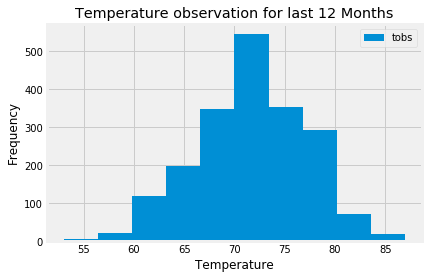

In [56]:
temp_observation_df.plot(kind='hist')
lables=['Date','best']
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.title('Temperature observation for last 12 Months')
plt.show()

![precipitation](Images/station-histogram.png)

In [ ]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    """TMIN, TAVG, and TMAX for a list of dates.
    
    Args:
        start_date (string): A date string in the format %Y-%m-%d
        end_date (string): A date string in the format %Y-%m-%d
        
    Returns:
        TMIN, TAVE, and TMAX
    """
    
    return session.query(func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)).\
        filter(Measurement.date >= start_date).filter(Measurement.date <= end_date).all()

# function usage example
print(calc_temps('2012-02-28', '2012-03-05'))

In [ ]:
# Use your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for your trip using the previous year's data for those same dates.


In [ ]:
# Plot the results from your previous query as a bar chart. 
# Use "Trip Avg Temp" as your Title
# Use the average temperature for the y value
# Use the peak-to-peak (tmax-tmin) value as the y error bar (yerr)


In [ ]:
# Calculate the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sort this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation



## Optional Challenge Assignment

In [ ]:
# Create a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    """Daily Normals.
    
    Args:
        date (str): A date string in the format '%m-%d'
        
    Returns:
        A list of tuples containing the daily normals, tmin, tavg, and tmax
    
    """
    
    sel = [func.min(Measurement.tobs), func.avg(Measurement.tobs), func.max(Measurement.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", Measurement.date) == date).all()
    
daily_normals("01-01")

In [ ]:
# calculate the daily normals for your trip
# push each tuple of calculations into a list called `normals`

# Set the start and end date of the trip

# Use the start and end date to create a range of dates

# Stip off the year and save a list of %m-%d strings

# Loop through the list of %m-%d strings and calculate the normals for each date


In [ ]:
# Load the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index


In [ ]:
# Plot the daily normals as an area plot with `stacked=False`
